In [51]:
import datetime
import json
import pandas as pd

# Define a dictionary to map sleep stage values to their corresponding labels
sleep_stage_labels = {
    1: "Awake (during sleep cycle)",
    2: "Sleep",
    3: "Out-of-bed",
    4: "Light sleep",
    5: "Deep sleep",
    6: "REM"
}

# Read sleep segment data from file
data = pd.read_json("..\Fit\All Data\derived_com.google.sleep.segment_com.google.an.json")
sleep_segments = data["Data Points"]

# Convert Epoch time to datetime objects and adjust dates
for segment in sleep_segments:
    start_time = datetime.datetime.fromtimestamp(int(segment["startTimeNanos"]) / 1e9)
    end_time = datetime.datetime.fromtimestamp(int(segment["endTimeNanos"]) / 1e9)
    if end_time.hour >= 16:
        segment_date = end_time.date()
    else:
        segment_date = start_time.date()
    segment["start_time"] = start_time
    segment["end_time"] = end_time
    segment["date"] = segment_date

# Calculate duration of each sleep segment in hours
for segment in sleep_segments:
    duration = (segment["end_time"] - segment["start_time"]).total_seconds() / 3600
    segment["duration"] = duration

# Group sleep segments by date and sum durations for each sleep stage
totals = {}
for segment in sleep_segments:
    date = segment["date"]
    sleep_stage = segment["fitValue"][0]["value"]["intVal"]
    if date not in totals:
        totals[date] = {label: 0 for label in sleep_stage_labels.values()}
    totals[date][sleep_stage_labels[sleep_stage]] += segment["duration"]

# Create a pandas DataFrame with date and hours slept for each sleep stage
df = pd.DataFrame.from_dict(totals, orient='index')
df.index.name = 'Date'
df.reset_index(inplace=True)

# Add a Total column to the DataFrame
df["Total"] = df.iloc[:, 1:].sum(axis=1)

# Calculate actual sleep time by subtracting "Awake" duration from "Total" duration
df["Actual Sleep Time"] = df["Total"] - df["Awake (during sleep cycle)"]

# Move "Actual Sleep Time" column to the left of "Total" column
df = df[["Date", "Awake (during sleep cycle)", "Sleep", "Out-of-bed", "Light sleep", "Deep sleep", "REM", "Actual Sleep Time", "Total"]]

# Sort the dataframe by date
df = df.sort_values(by="Date")

print(df)

           Date  Awake (during sleep cycle)  Sleep  Out-of-bed  Light sleep   
537  2019-07-28                    0.066667    0.0           0     0.958333  \
538  2019-07-29                    0.983333    0.0           0     3.691667   
539  2019-07-30                    0.783333    0.0           0     5.158333   
540  2019-07-31                    0.566667    0.0           0     3.675000   
541  2019-08-01                    0.008333    0.0           0     0.991667   
..          ...                         ...    ...         ...          ...   
532  2023-04-27                    0.716667    0.0           0     4.133333   
533  2023-04-28                    0.900000    0.0           0     5.366667   
534  2023-04-29                    1.133333    0.0           0     6.650000   
535  2023-04-30                    0.049999    0.0           0     0.916665   
536  2023-05-01                    0.533327    0.0           0     4.566658   

     Deep sleep       REM  Actual Sleep Time     To

In [52]:
df

,Date,Awake (during sleep cycle),Sleep,Out-of-bed,Light sleep,Deep sleep,REM,Actual Sleep Time,Total
537,2019-07-28,0.066667,0.0,0,0.958333,0.083333,0.000000,1.041667,1.108333
538,2019-07-29,0.983333,0.0,0,3.691667,1.416667,1.925000,7.033333,8.016667
539,2019-07-30,0.783333,0.0,0,5.158333,1.933333,2.058333,9.150000,9.933333
540,2019-07-31,0.566667,0.0,0,3.675000,0.466667,2.175000,6.316667,6.883333
541,2019-08-01,0.008333,0.0,0,0.991667,0.641667,0.158333,1.791667,1.800000
...,...,...,...,...,...,...,...,...,...
532,2023-04-27,0.716667,0.0,0,4.133333,0.000000,2.516667,6.650000,7.366666
533,2023-04-28,0.900000,0.0,0,5.366667,0.700000,1.966667,8.033334,8.933334
534,2023-04-29,1.133333,0.0,0,6.650000,0.416667,1.550000,8.616667,9.750000
535,2023-04-30,0.049999,0.0,0,0.916665,0.566666,0.033333,1.516664,1.566663


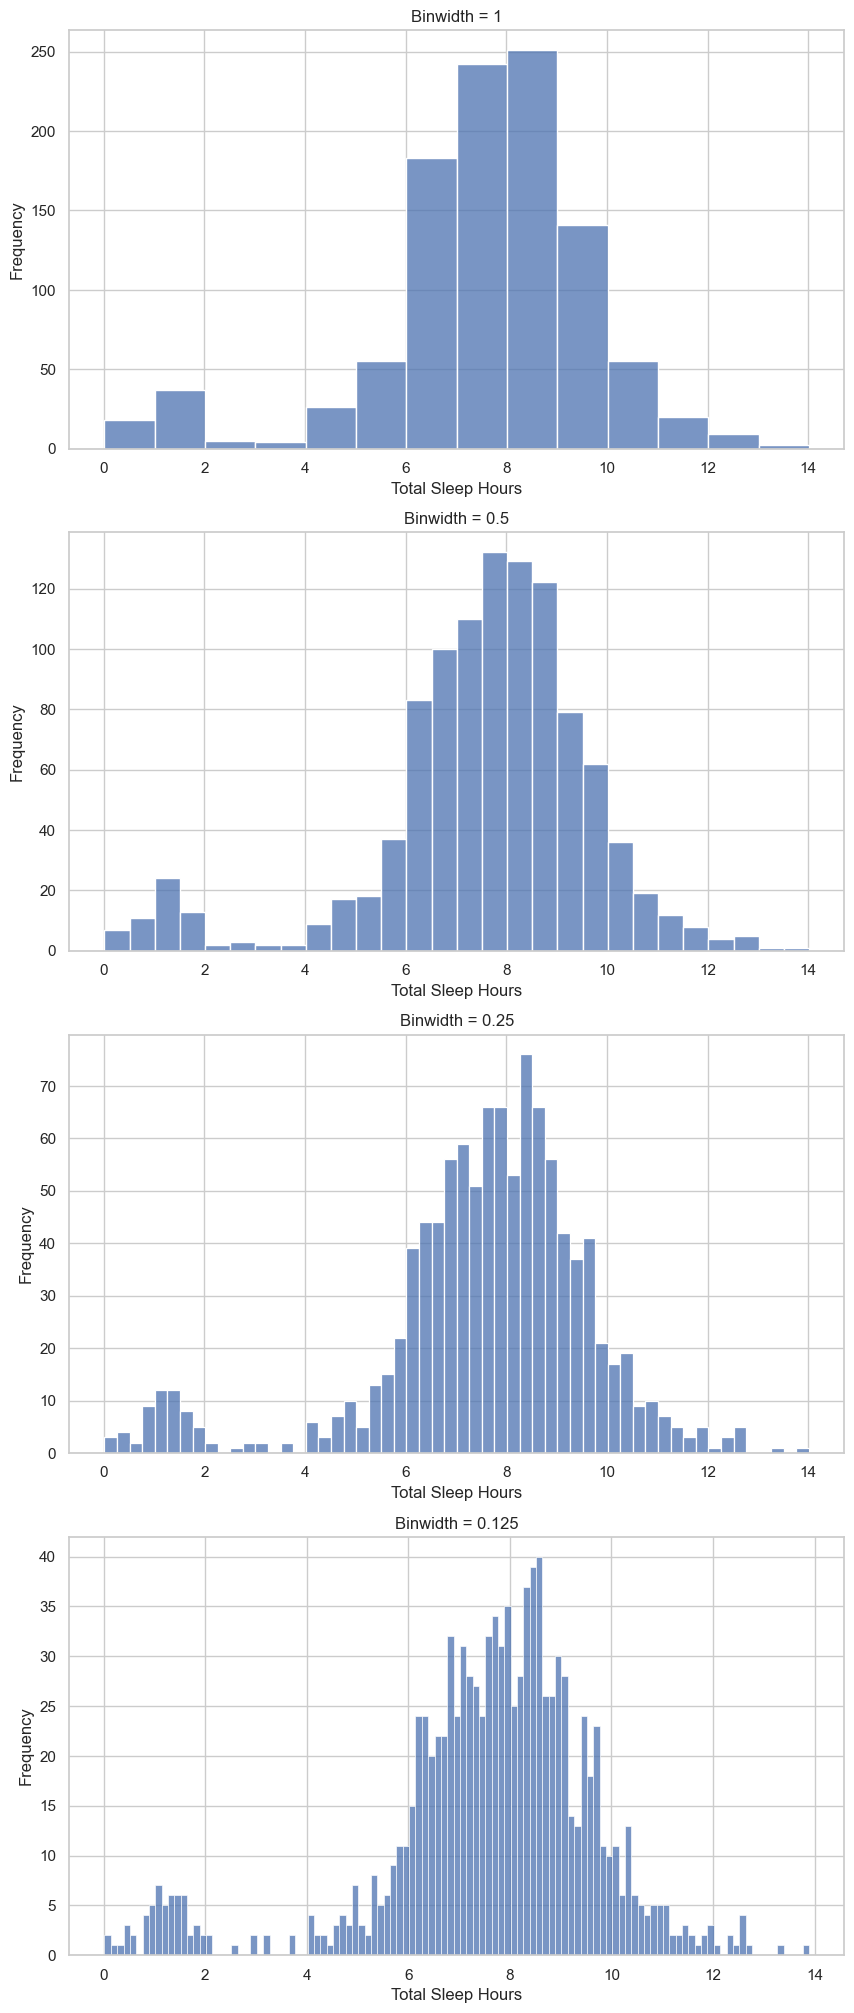

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with three subplots
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10,25))

# Set binwidths for each plot
binwidths = [1, 0.5, 0.25, 0.125]

# Loop through subplots and plot histograms with corresponding binwidths
for i in range(4):
    ax = axs[i]
    sns.histplot(data=df, x="Total", binwidth=binwidths[i], ax=ax)
    ax.set_xlabel("Total Sleep Hours")
    ax.set_ylabel("Frequency")
    ax.set_title("Binwidth = {}".format(binwidths[i]))

# Show the plot
plt.show()

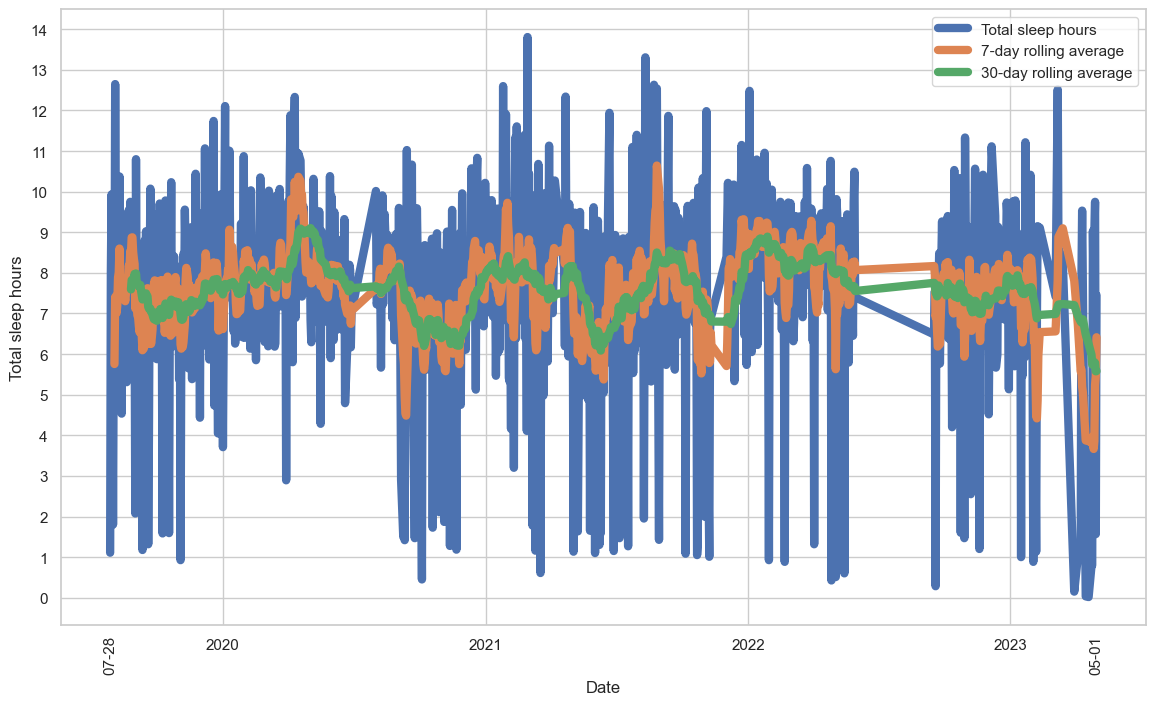

In [54]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator, FixedLocator

# Calculate rolling averages
df["7-day rolling average"] = df["Total"].rolling(window=7).mean()
df["30-day rolling average"] = df["Total"].rolling(window=30).mean()

# Plot the data
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(df["Date"], df["Total"], linewidth=6, label="Total sleep hours")
ax.plot(df["Date"], df["7-day rolling average"], linewidth=6, label="7-day rolling average")
ax.plot(df["Date"], df["30-day rolling average"], linewidth=6, label="30-day rolling average")

# Set tick marks on the y-axis every hour
ax.yaxis.set_major_locator(MultipleLocator(1))

# Set tick marks on the x-axis at the start of every year, the first date, and the last date
start_date = df["Date"].iloc[0]
end_date = df["Date"].iloc[-1]
year_start = mdates.MonthLocator(bymonth=1, bymonthday=1)
first_date = FixedLocator([mdates.date2num(start_date)])
last_date = FixedLocator([mdates.date2num(end_date)])
ax.xaxis.set_major_locator(year_start)
ax.xaxis.set_minor_locator(FixedLocator([mdates.date2num(start_date), mdates.date2num(end_date)]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m-%d'))
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)

# Set axis labels and legend
ax.set_xlabel("Date")
ax.set_ylabel("Total sleep hours")
ax.legend()

# Show the plot
plt.show()


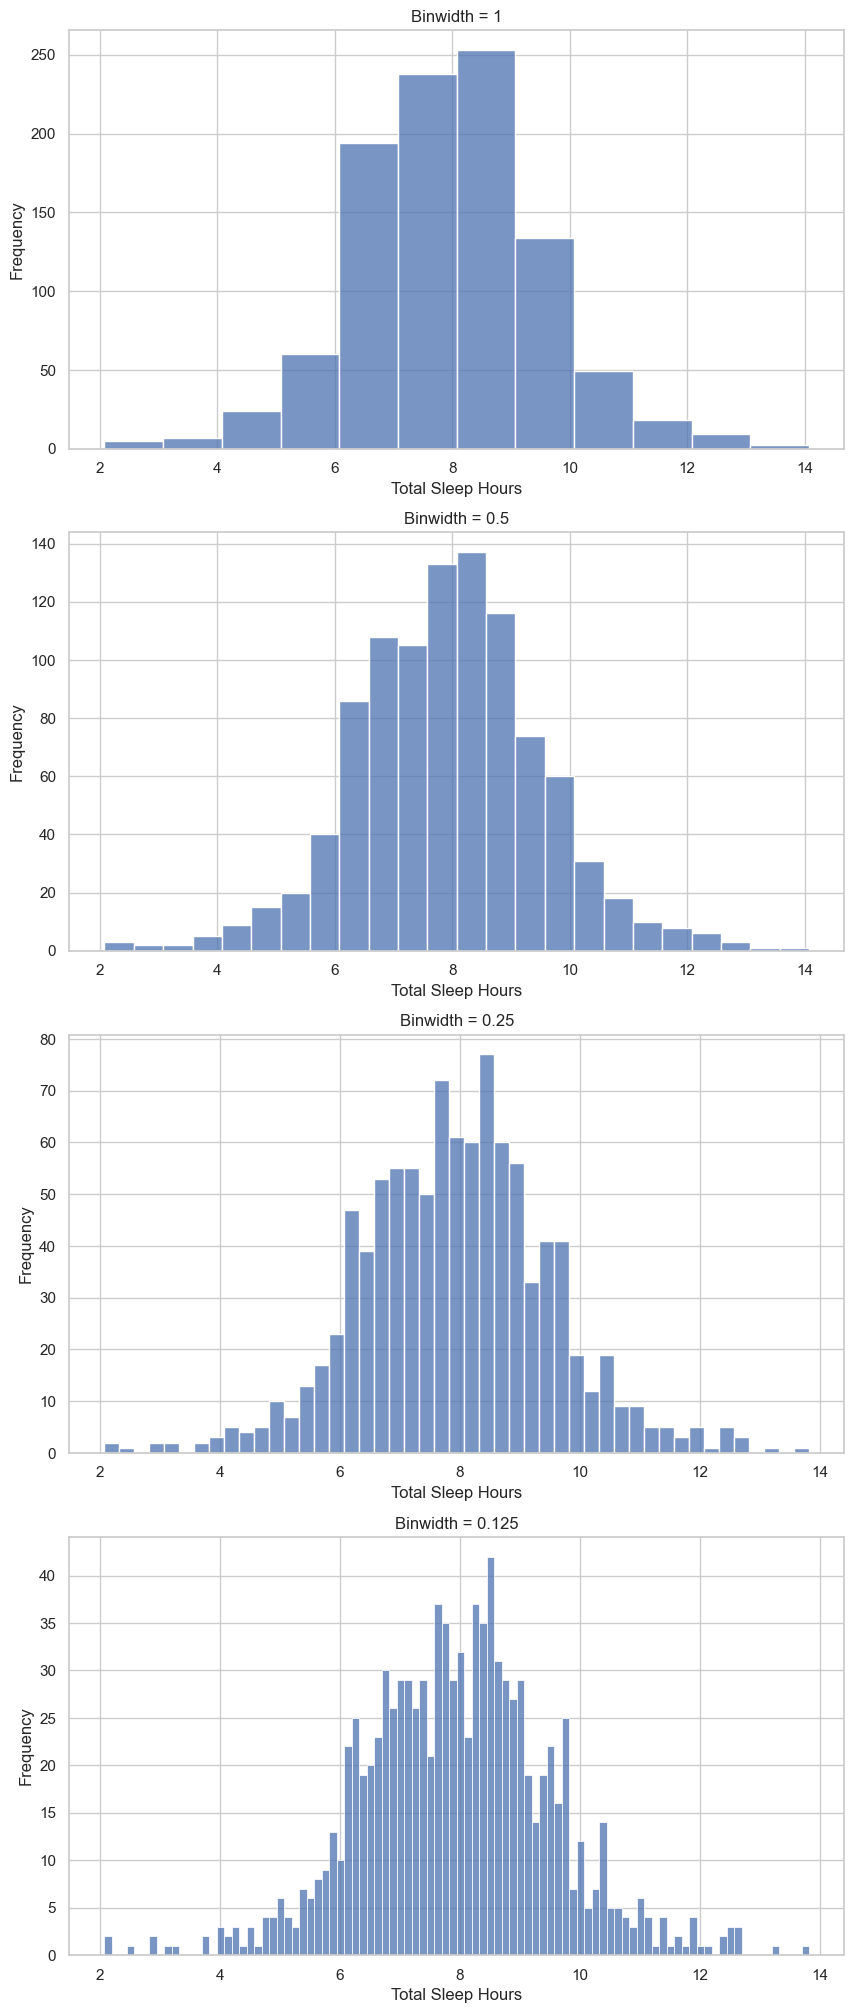

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out data with less than 2 hours of sleep
df_filtered = df[df["Total"] >= 2]

# Create a figure with four subplots
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10,25))

# Set binwidths for each plot
binwidths = [1, 0.5, 0.25, 0.125]

# Loop through subplots and plot histograms with corresponding binwidths
for i in range(4):
    ax = axs[i]
    sns.histplot(data=df_filtered, x="Total", binwidth=binwidths[i], ax=ax)
    ax.set_xlabel("Total Sleep Hours")
    ax.set_ylabel("Frequency")
    ax.set_title("Binwidth = {}".format(binwidths[i]))

# Show the plot
plt.show()

C:\Users\judea\AppData\Local\Temp\ipykernel_40240\246497505.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["7-day rolling average"] = df["Total"].rolling(window=7).mean()
C:\Users\judea\AppData\Local\Temp\ipykernel_40240\246497505.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["30-day rolling average"] = df["Total"].rolling(window=30).mean()


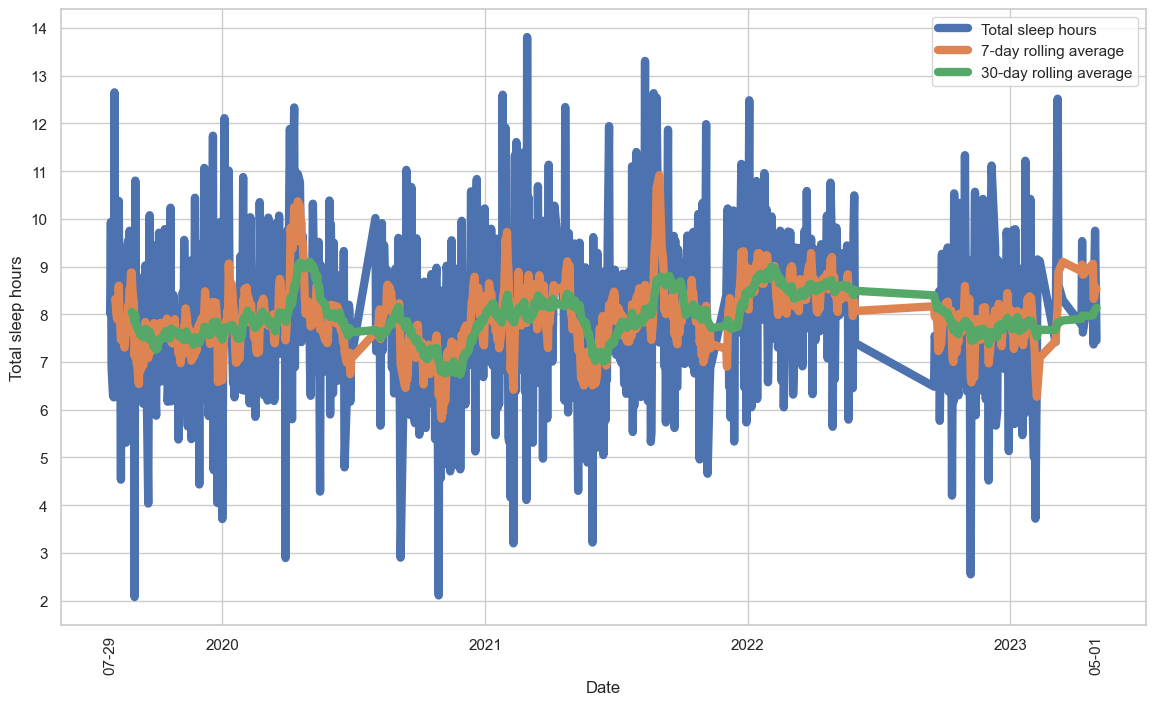

In [56]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator, FixedLocator

# Filter out data with less than 2 hours of sleep
df = df[df["Total"] >= 2]

# Calculate rolling averages
df["7-day rolling average"] = df["Total"].rolling(window=7).mean()
df["30-day rolling average"] = df["Total"].rolling(window=30).mean()

# Plot the data
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(df["Date"], df["Total"], linewidth=6, label="Total sleep hours")
ax.plot(df["Date"], df["7-day rolling average"], linewidth=6, label="7-day rolling average")
ax.plot(df["Date"], df["30-day rolling average"], linewidth=6, label="30-day rolling average")

# Set tick marks on the y-axis every hour
ax.yaxis.set_major_locator(MultipleLocator(1))

# Set tick marks on the x-axis at the start of every year, the first date, and the last date
start_date = df["Date"].iloc[0]
end_date = df["Date"].iloc[-1]
year_start = mdates.MonthLocator(bymonth=1, bymonthday=1)
first_date = FixedLocator([mdates.date2num(start_date)])
last_date = FixedLocator([mdates.date2num(end_date)])
ax.xaxis.set_major_locator(year_start)
ax.xaxis.set_minor_locator(FixedLocator([mdates.date2num(start_date), mdates.date2num(end_date)]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m-%d'))
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)

# Set axis labels and legend
ax.set_xlabel("Date")
ax.set_ylabel("Total sleep hours")
ax.legend()

# Show the plot
plt.show()

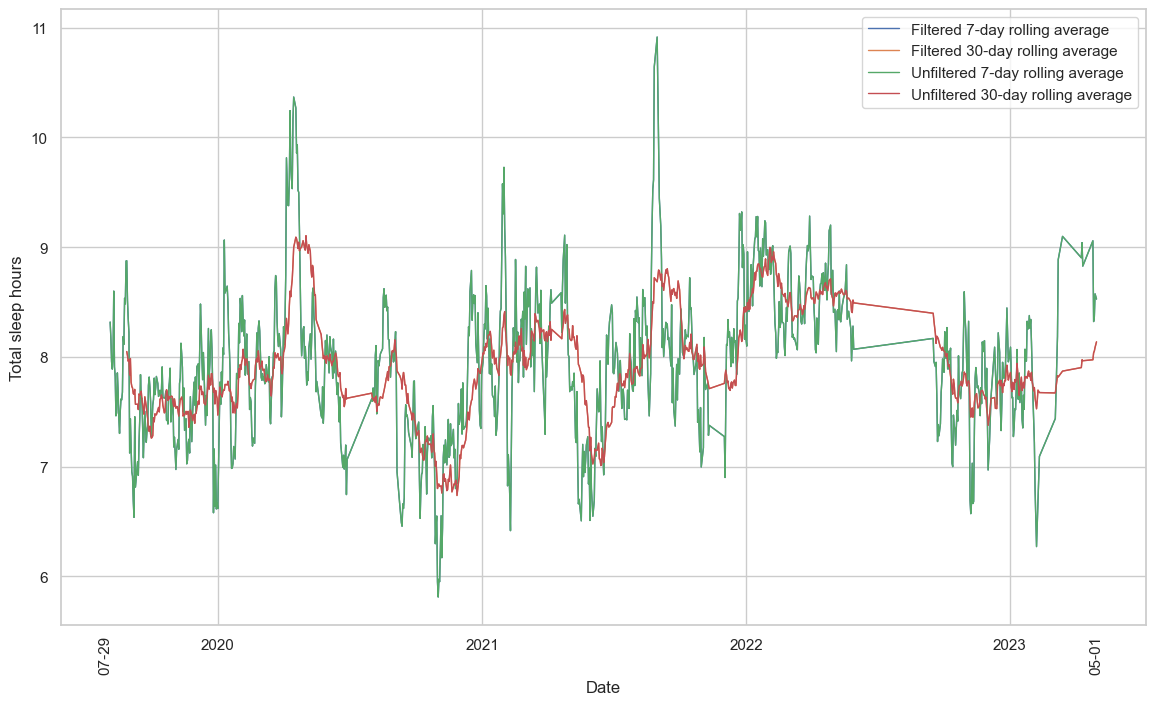

In [62]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator, FixedLocator

# Calculate rolling averages for filtered data
df_filtered = df[df["Total"] >= 2]
df_filtered["7-day rolling average"] = df_filtered["Total"].rolling(window=7).mean()
df_filtered["30-day rolling average"] = df_filtered["Total"].rolling(window=30).mean()

# Calculate rolling averages for unfiltered data
df_unfiltered = df.copy()
df_unfiltered["7-day rolling average"] = df_unfiltered["Total"].rolling(window=7).mean()
df_unfiltered["30-day rolling average"] = df_unfiltered["Total"].rolling(window=30).mean()

# Plot the data
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(df_filtered["Date"], df_filtered["7-day rolling average"], linewidth=1, label="Filtered 7-day rolling average")
ax.plot(df_filtered["Date"], df_filtered["30-day rolling average"], linewidth=1, label="Filtered 30-day rolling average")
ax.plot(df_unfiltered["Date"], df_unfiltered["7-day rolling average"], linewidth=1, label="Unfiltered 7-day rolling average")
ax.plot(df_unfiltered["Date"], df_unfiltered["30-day rolling average"], linewidth=1, label="Unfiltered 30-day rolling average")

# Set tick marks on the y-axis every hour
ax.yaxis.set_major_locator(MultipleLocator(1))

# Set tick marks on the x-axis at the start of every year, the first date, and the last date
start_date = df["Date"].iloc[0]
end_date = df["Date"].iloc[-1]
year_start = mdates.MonthLocator(bymonth=1, bymonthday=1)
first_date = FixedLocator([mdates.date2num(start_date)])
last_date = FixedLocator([mdates.date2num(end_date)])
ax.xaxis.set_major_locator(year_start)
ax.xaxis.set_minor_locator(FixedLocator([mdates.date2num(start_date), mdates.date2num(end_date)]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m-%d'))
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)

# Set axis labels and legend
ax.set_xlabel("Date")
ax.set_ylabel("Total sleep hours")
ax.legend()

# Show the plot
plt.show()

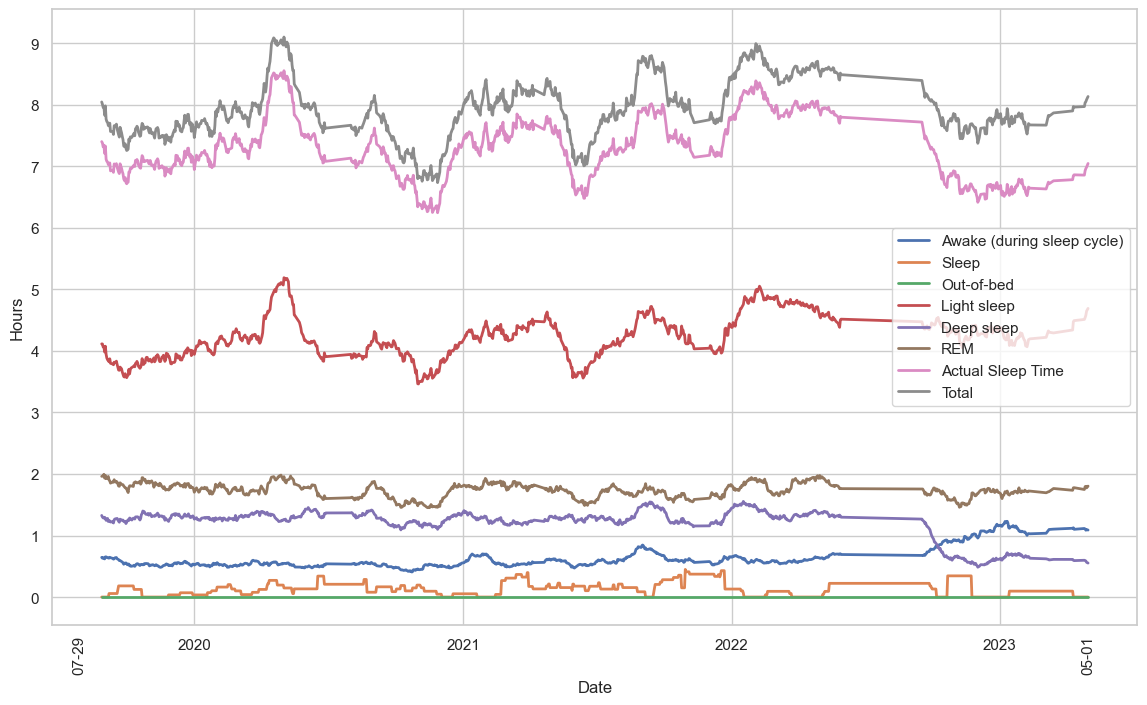

In [68]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator, FixedLocator

# Filter out data with less than 2 hours of sleep
df = df[df["Total"] >= 2]

# Calculate rolling averages
categories = ["Awake (during sleep cycle)", "Sleep", "Out-of-bed", "Light sleep", "Deep sleep", "REM", "Actual Sleep Time", "Total"]
for category in categories:
    df[category + " 30-day rolling average"] = df[category].rolling(window=30).mean()

# Plot the data
fig, ax = plt.subplots(figsize=(14, 8))
for category in categories:
    ax.plot(df["Date"], df[category + " 30-day rolling average"], linewidth=2, label=category)

# Set tick marks on the y-axis every hour
ax.yaxis.set_major_locator(MultipleLocator(1))

# Set tick marks on the x-axis at the start of every year, the first date, and the last date
start_date = df["Date"].iloc[0]
end_date = df["Date"].iloc[-1]
year_start = mdates.MonthLocator(bymonth=1, bymonthday=1)
first_date = FixedLocator([mdates.date2num(start_date)])
last_date = FixedLocator([mdates.date2num(end_date)])
ax.xaxis.set_major_locator(year_start)
ax.xaxis.set_minor_locator(FixedLocator([mdates.date2num(start_date), mdates.date2num(end_date)]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m-%d'))
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)

# Set axis labels and legend
ax.set_xlabel("Date")
ax.set_ylabel("Hours")
ax.legend()

# Show the plot
plt.show()

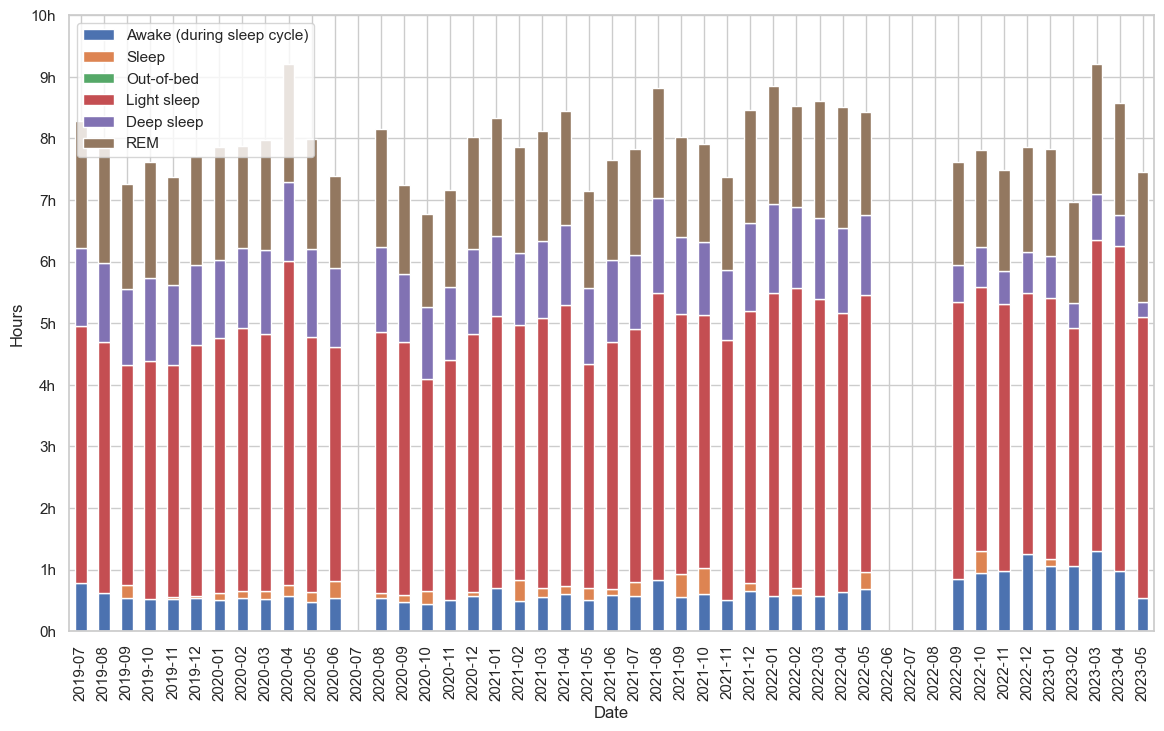

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter out data with less than 2 hours of sleep
df_filtered = df[df["Total"] >= 2]

# Calculate monthly averages
categories = ["Awake (during sleep cycle)", "Sleep", "Out-of-bed", "Light sleep", "Deep sleep", "REM"]
df_monthly = df_filtered.resample('M', on='Date')[categories].mean()

# Reformat the Date column to remove the timestamp
df_monthly.index = df_monthly.index.strftime('%Y-%m')

# Plot the data as stacked bar chart
fig, ax = plt.subplots(figsize=(14, 8))
df_monthly.plot(kind='bar', stacked=True, ax=ax)

# Set axis labels and legend
ax.set_xlabel("Date")
ax.set_ylabel("Hours")
ax.legend(loc='upper left')

# Set y-axis ticks and labels
yticks = range(0, 11)
yticklabels = [f"{h}h" for h in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

# Show the plot
plt.show()